## Presence of tfs family in different cell line

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from comut import comut
import seaborn as sns
from pathlib import Path

In [ ]:
plt.rcParams['figure.dpi'] = 150

In [ ]:
safari_options = Options()
safari_options.add_argument("headless")

In [ ]:
baseurl = r'https://www.encodeproject.org/matrix/?type=Experiment&control_type%21=%2A&status=released&perturbed=false&assay_title=TF+ChIP-seq&target.investigated_as=transcription+factor&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.classification=cell+line&biosample_ontology.term_name='

In [ ]:
# select cell : HepG2, K562, HEK293, GM12878, MCF-7, WTC11, A549, SK-N-SH, HeLa-S3, H1

In [ ]:
cell_lines = []
tfs = []
counts = []

for cellline in ['HepG2', 'K562', 'HEK293', 'GM12878', 'MCF-7', 'WTC11', 'A549', 'SK-N-SH', 'HeLa-S3', 'H1']:
    url = baseurl + cellline
    dr = webdriver.Safari(options=safari_options)
    dr.implicitly_wait(10)
    dr.get(url)
    dr.implicitly_wait(10)
    tfs_div = dr.find_element(By.XPATH,'//*[@id="facet-group-Assay-Experiment"]/div[4]/div/div[2]/ul/div[1]')
    tf_div = tfs_div.find_elements(By.CLASS_NAME, 'facet-term')
    for index, tf in enumerate(tf_div):
        cell_lines.append(cellline)
        tfs.append(tf.find_element(By.CLASS_NAME, 'facet-term__text').text)
        counts.append(tf.find_element(By.CLASS_NAME, 'facet-term__count').text)
    dr.quit()


In [ ]:
tfs_data_encode = pd.DataFrame({
    "Cell" : cell_lines,
    "TF" : tfs,
    "Count" : counts
})

In [ ]:
tfs_data_encode.groupby('Cell').size()

In [ ]:
tfs_family = pd.read_csv('data/tfs_family.csv')
tfs_family_dict = dict(tfs_family[['Name','Family']].values)

# add Unkonw
for i in tfs_data_encode['TF']:
    if i in tfs_family_dict.keys():
        pass
    else:
        tfs_family_dict[i] = "Unknown"



In [ ]:
tfs_data_encode['Family'] = [ tfs_family_dict[i] for i in tfs_data_encode['TF'] ]

In [ ]:
sns.barplot(tfs_data_encode.groupby(['Cell', 'Family']).size().reset_index(name="Count"), x = "Family", y="Count", hue="Cell")
plt.tick_params(axis='x', labelrotation=45)
plt.show()

In [ ]:
tfs_data_encode.groupby(['Cell', 'Family']).size()

In [ ]:
len(tfs_data_encode.drop_duplicates('Family')['Family'])

In [ ]:
comut_data = tfs_data_encode.groupby(['Cell', 'Family']).size().reset_index(name="Count")
comut_data.columns = ['category', 'sample', 'value']
#comut_data['value'] = [ 1/ (1 + np.exp(-i)) for i in comut_data['value'].tolist() ]
comut_data['value'] = "1"

In [ ]:
family_comut = comut.CoMut()
mut_mapping={"1":"#4876FF"}
family_comut.add_categorical_data(comut_data, name='type',mapping=mut_mapping)
#family_comut.add_continuous_data(comut_data, name='type')
family_comut.plot_comut(figsize = (10,3),x_padding = 0.04, y_padding = 0.04)
plt.savefig("results/encode.tf.family.pdf")

## Spider - Encode Project for each cell line

In [ ]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.by import By
from selenium.webdriver.safari.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd

In [ ]:
#encode_hg19 = pd.read_csv('/Users/cmf/Downloads/TFNet-single-tf/data/encode/encode.report.select.cell.tfs.hg19.tsv',header=0, sep='\t',skiprows=1)
encode_hg19 = pd.read_csv('/Users/cmf/Downloads/TFNet-single-tf/data/encode/encode.report.select.cell.tfs.hg19.tsv',header=0, sep='\t')
encode_grch38 = pd.read_csv('/Users/cmf/Downloads/TFNet-single-tf/data/encode/encode.report.select.cell.tfs.grch38.tsv',header=0, sep='\t')
encode_hg19[['Accession', 'Target gene symbol', 'Biosample term name']]

In [ ]:

base_url = 'https://www.encodeproject.org/experiments/'

In [ ]:
safari_options = Options()
safari_options.add_argument("headless")

In [ ]:
projects = []
file_accessions= []
file_types = []
output_types = []
isogenic_replicates = []
genomes = []
encode_pipes = []

dr = webdriver.Safari(options=safari_options)
dr.implicitly_wait(10)

#for accession in encode_hg19['Accession']:
for accession in encode_hg19['Accession']:
    url = base_url + accession
    dr.get(url)
    sleep(3)
    dr.find_element(By.XPATH,'//*[@id="content"]/div/div[3]/div[2]/div[2]/div[1]/ul/li[3]/a').send_keys(Keys.ENTER)
    try:
        WebDriverWait(dr,10,0.2).until(EC.presence_of_element_located((By.XPATH,'//*[@id="tables"]/div/div[2]/div[2]/div')))
    except TimeoutException:
        sleep(3)
    encode_div = dr.find_element(By.XPATH, '//*[@id="tables"]/div/div[2]/div[2]/div')
    for index, table in enumerate(encode_div.find_elements(By.CLASS_NAME,'table__sortable')):
        if index != 0:
            if table.find_element(By.CLASS_NAME, 'title-main-content__analysis-title').text.find("hg19") !=-1 :
                encode_pipe = table.find_element(By.CLASS_NAME, 'title-main-content__analysis-title').text.split(" ")[0]
                tbody = table.find_element(By.TAG_NAME,'tbody')
                for tr in tbody.find_elements(By.TAG_NAME,'tr'):
                    tds = tr.find_elements(By.TAG_NAME,'td')
                    if tds[2].text == 'bed narrowPeak' and tds[3].text == 'optimal IDR thresholded peaks':
                        projects.append(accession)
                        genomes.append("hg19")
                        href = tds[0].find_element(By.TAG_NAME,'a').get_attribute('href')
                        file_accessions.append(href.split("/")[4])
                        file_types.append(tds[2].text)
                        output_types.append(tds[3].text)
                        isogenic_replicates.append(tds[4].text)
                        encode_pipes.append(encode_pipe)
                        print(accession)


dr.quit()


encode_hg19_spider = pd.DataFrame({
    "project" : projects,
    "genome" : genomes,
    "file_accession" : file_accessions,
    "type" : file_types,
    "output_type" : output_types,
    "replicates" : isogenic_replicates,
    "pipe": encode_pipes
})

encode_hg19_spider.to_csv("data/encode/encode_hg19_spider.csv",header=True, index=False)




In [ ]:
projects = []
file_accessions= []
file_types = []
output_types = []
isogenic_replicates = []
genomes = []
encode_pipes = []

dr = webdriver.Safari(options=safari_options)
dr.implicitly_wait(10)

#for accession in encode_grch38['Accession']:
for accession in encode_grch38['Accession']:
    url = base_url + accession
    dr.get(url)
    sleep(3)
    dr.find_element(By.XPATH,'//*[@id="content"]/div/div[3]/div[2]/div[2]/div[1]/ul/li[3]/a').send_keys(Keys.ENTER)
    try:
        WebDriverWait(dr,10,0.2).until(EC.presence_of_element_located((By.XPATH,'//*[@id="tables"]/div/div[2]/div[2]/div')))
    except TimeoutException:
        sleep(3)
    encode_div = dr.find_element(By.XPATH, '//*[@id="tables"]/div/div[2]/div[2]/div')
    for index, table in enumerate(encode_div.find_elements(By.CLASS_NAME,'table__sortable')):
        if index != 0:
            if table.find_element(By.CLASS_NAME, 'title-main-content__analysis-title').text.find("GRCh38") !=-1 :
                encode_pipe = table.find_element(By.CLASS_NAME, 'title-main-content__analysis-title').text.split(" ")[0]
                tbody = table.find_element(By.TAG_NAME,'tbody')
                for tr in tbody.find_elements(By.TAG_NAME,'tr'):
                    tds = tr.find_elements(By.TAG_NAME,'td')
                    if tds[2].text == 'bed narrowPeak' and (tds[3].text == 'optimal IDR thresholded peaks' or tds[3].text == 'IDR thresholded peaks'):
                        projects.append(accession)
                        print(accession)
                        genomes.append("GRCh38")
                        href = tds[0].find_element(By.TAG_NAME,'a').get_attribute('href')
                        file_accessions.append(href.split("/")[4])
                        file_types.append(tds[2].text)
                        output_types.append(tds[3].text)
                        isogenic_replicates.append(tds[4].text)
                        encode_pipes.append(encode_pipe)


dr.quit()

#encode_grch38_spider = pd.DataFrame({
encode_grch38_spider = pd.DataFrame({
    "project" : projects,
    "genome" : genomes,
    "file_accession" : file_accessions,
    "type" : file_types,
    "output_type" : output_types,
    "replicates" : isogenic_replicates,
    "pipe": encode_pipes
})

encode_grch38_spider.to_csv("data/encode/encode_grch38_spider.csv",header=True, index=False)

### compare tfs collected from encode to all tf_pseudo

In [ ]:
encode_hg19_spider = pd.read_csv("data/encode/encode_hg19_spider.csv",header=0)
encode_grch38_spider = pd.read_csv("data/encode/encode_grch38_spider.csv",header=0)

In [ ]:
encode_hg19_tfs = list(set(encode_hg19['Target gene symbol']))
encode_grch38_tfs = list(set(encode_grch38['Target gene symbol']))



In [ ]:
pseudo_tfs = []
with open('data/tf_pseudo/tf_pseudo.txt') as fp:
    for line in fp:
        if line.rstrip() != "":
            pseudo_tfs.append(line.rstrip())

In [ ]:
hg19_no_pseudo_tfs = []
for i in encode_hg19_tfs:
    if i in pseudo_tfs:
        pass
    else:
        hg19_no_pseudo_tfs.append(i)

grch38_no_pseudo_tfs = []
for i in encode_grch38_tfs:
    if i in pseudo_tfs:
        pass
    else:
        grch38_no_pseudo_tfs.append(i)


no_pseudo_tfs = set(hg19_no_pseudo_tfs + grch38_no_pseudo_tfs)

In [ ]:
# for tfnet_5
shared_tfs = ["CEBPB","CTCF","EGR1","JUND","MAX","MYC","NRF1","REST","RFX5","SIX5","SP1","SRF","USF2","YY1","ZNF143"]

sum([ i in pseudo_tfs for i in shared_tfs])

### Down load bed file for each tf

#### for hg19

In [ ]:
encode_hg19_spider = pd.read_csv("data/encode/encode_hg19_spider.csv",header=0)

: 

In [ ]:
# find no duplicates for encode_hg19_spider
len(encode_hg19_spider) - len(encode_hg19_spider.drop_duplicates('project'))

In [ ]:
encode_hg19_spider.groupby('project').apply(lambda x : x.sort_values('replicates').head(1))

In [ ]:
encode_hg19_spider[[ len(i) != 11 for i in encode_hg19_spider['file_accession']]]

In [ ]:
encode_hg19_short = encode_hg19[['Accession', 'Target gene symbol', 'Biosample term name']]
encode_hg19_short.columns = ['project', 'Target', 'Biosample']
hg19 = pd.merge(encode_hg19_spider, encode_hg19_short, on='project', how='left')

# drop duplicates
hg19.drop_duplicates(['Target','Biosample']).to_csv("data/encode/encode_hg19_spider.download.csv",header=True, index=False)

#### for grch38

In [ ]:
encode_grch38_spider = pd.read_csv("data/encode/encode_grch38_spider.csv",header=0)

In [ ]:
len(encode_grch38_spider) - len(encode_grch38_spider.drop_duplicates('project'))

In [ ]:
encode_grch38_spider_encode3 = encode_grch38_spider[encode_grch38_spider['pipe'] == "ENCODE3"]
encode_grch38_spider_encode4 = encode_grch38_spider[encode_grch38_spider['pipe'] == "ENCODE4"]

print(len(set(encode_grch38_spider_encode3['project'])))
print(len(set(encode_grch38_spider_encode4['project'])))

### almost all project in encode3 pipeline are covered by encode4, choose encode4 to download bed file
print(len(set(encode_grch38_spider_encode3['project'])) - sum(encode_grch38_spider_encode3['project'].isin(encode_grch38_spider_encode4['project'])) )

In [ ]:
# no replicates present as nan in grch38
# sum(encode_grch38_spider_encode4['replicates'].isna()) == 0
# filter for replicates
encode_grch38_spider_encode4_filter = encode_grch38_spider_encode4[[ j == 1 for j in [ i.find(",") for i in encode_grch38_spider_encode4['replicates']]]]

# 1855
len(set(encode_grch38_spider_encode4_filter['project']))
# 1891
len(encode_grch38_spider_encode4_filter)
# show duplicates
encode_grch38_spider_encode4_filter[encode_grch38_spider_encode4_filter.duplicated('project', keep=False).tolist()]

In [ ]:
encode_grch38_spider_encode4_filter = encode_grch38_spider_encode4_filter.groupby('project').apply(lambda x : x.head(1)).reset_index(drop=True)

In [ ]:
encode_grch38_short = encode_grch38[['Accession', 'Target gene symbol', 'Biosample term name']]
encode_grch38_short.columns = ['project', 'Target', 'Biosample']
grch38 = pd.merge(encode_grch38_spider_encode4_filter, encode_grch38_short, on='project', how='left')

# drop duplicates

#grch38.drop_duplicates(['Target','Biosample']).to_csv("data/encode/encode_grch38_spider.download.csv",header=True, index=False)
grch38 = grch38.drop_duplicates(['Target','Biosample'])

### most of the unmatch target tfs were non-Homo_sapiens or unknow family or can not find in cisbp database

In [ ]:
filter_grch38_no_pseudo_tfs = []
for i in set(grch38[grch38['Biosample'] != 'HEK293']['Target']):
    if i in pseudo_tfs:
        pass
    else:
        filter_grch38_no_pseudo_tfs.append(i)


print(len(set(filter_grch38_no_pseudo_tfs)))
### most of the unmatch target tfs were non-Homo_sapiens or unknow family or can not find in cisbp database

### Make txt for download

In [ ]:
# url format 'https://www.encodeproject.org/files/ENCFF795AWO/@@download/ENCFF795AWO.bed.gz'
# wget all file
base_url = 'https://www.encodeproject.org/files'
file_format = '.bed.gz'
extra = '@@download'

with open('data/encode/encode_grch38.download', 'w') as fp:
    #for i in encode_grch38_spider_encode4_filter['file_accession']:
    for i in grch38['file_accession']:
        fp.write(f'{base_url}/{i}/{extra}/{i}{file_format}\n')


with open('data/encode/encode_hg19.download', 'w') as fp:
    #for i in encode_hg19_spider['file_accession']:
    for i in hg19['file_accession']:
        fp.write(f'{base_url}/{i}/{extra}/{i}{file_format}\n')

### exclude HEK293 due to lack of DNAse data

In [ ]:
# if exclude WTC11 SK-N-SH and HEK293
# if exclude SK-N-SH  # due to lack of dnase seq data

In [ ]:
#exclude_cells = ["WTC11", "SK-N-SH", "HEK293"]
#exclude_cell = ["WTC11"]
exclude_cell = ["HEK293"]

grch38 = pd.merge(encode_grch38_spider_encode4_filter, encode_grch38_short, on='project', how='left')
hg19 = pd.merge(encode_hg19_spider, encode_hg19_short, on='project', how='left')

nohek293_grch38 = grch38[~grch38['Biosample'].isin(exclude_cell)]

print(len(set(grch38['Target'])) - len(set(grch38[~grch38['Biosample'].isin(exclude_cell)]['Target'])))
print(len(set(hg19['Target'])) - len(set(hg19[~hg19['Biosample'].isin(exclude_cell)]['Target'])))

### plot the presence of all tfs in encode and pseudos

In [ ]:
directory_path = Path("data/tf_pseudo/")
pseudo_tfs = []
tf_family = []
for file_path in list(directory_path.glob("*.fa")):
    print(file_path)
    with open(file_path,'r') as fp:
        for line in fp:
            if line.startswith(">"):
                pseudo_tfs.append(line.lstrip(">").rstrip())
                tf_family.append(Path(file_path).stem)

tfs_family = pd.DataFrame({"Target": pseudo_tfs,
                           "family":tf_family
                           })


#tfs_family['chip'] = tfs_family['tf'].isin(set(grch38['Target'])).astype(int)
tfs_family['chip'] = tfs_family['Target'].isin(set(nohek293_grch38['Target'])).astype(int)


#grch38 = pd.merge(nohek293_grch38, tfs_family, on='Target', how='left')

In [ ]:
# if select specific superfamily, check the celltype diversity
nohek293_grch38[nohek293_grch38['Target'].isin(set(tfs_family[(tfs_family['chip']==1) & (tfs_family['family'] == 'THAP&SAND&GTF2I&BrkDBD')]['Target']))]

In [ ]:
#select bZIP_1
nohek293_grch38[nohek293_grch38['Target'].isin(set(tfs_family[(tfs_family['chip']==1) & (tfs_family['family'] == 'bZIP_1')]['Target']))]


### All tfs for training (with matched pseudosequences)
#### have to remove some chip-data due to lack of matched pseudosequences

In [ ]:
target_family = dict(zip(tfs_family['Target'],tfs_family['family']))

In [ ]:
tfs_family.columns =  ['sample','category','value']
all_tfs_training = list(tfs_family['sample'][tfs_family['value'] == 1])
all_tfs_training.sort()


with open('data/encode/all_tfs.family.training', 'w') as fp:
    for i in all_tfs_training:
        fp.write(i+"\t"+ target_family[i] + "\n")



with open('data/encode/all_tfs.training', 'w') as fp:
    for i in all_tfs_training:
        fp.write(i+"\n")



### Plot

In [ ]:
pseudo_family_comut = comut.CoMut()
mut_mapping={1:"red", 0: "grey"}
#pseudo_family_comut.add_categorical_data(tfs_family[tfs_family['category']== 'THAP&SAND&GTF2I&BrkDBD'], name='value',mapping=mut_mapping)
pseudo_family_comut.add_categorical_data(tfs_family, name='value',mapping=mut_mapping)

#family_comut.add_continuous_data(comut_data, name='type')
pseudo_family_comut.plot_comut(figsize = (30,9),x_padding = 0.04, y_padding = 0.04)
plt.xticks([])  
plt.savefig("results/pseudo_family.nohek293.pdf")

### Plot cell type / tfs datatable

In [4]:
download_table = pd.read_csv("/Users/cmf/Downloads/TFNet-single-tf/data/encode/encode_grch38_spider.download.csv", header=0)
download_table = download_table[['Target', 'Biosample']]
download_table = download_table[~download_table['Biosample'].isin(["HEK293"])]
download_table['value'] = 1
download_table.columns =  ['sample','category','value']
download_table = download_table.sort_values(["category","sample"])

#download_table.pivot_table(index="Target", columns="Biosample", values="value")

In [6]:
tfs_family = pd.read_csv('/Users/cmf/Downloads/TFNet-single-tf/data/tfs_family.csv')
tfs_family_dict = dict(tfs_family[['Name','Family']].values)
tfs_family_dict.update({key :"Unknown" for key in set(download_table['sample'][~download_table['sample'].isin(tfs_family['Name'])].tolist())})

download_table['family'] = [tfs_family_dict[i] for i in download_table['sample']]

In [9]:
download_table.sort_values("category")

,sample,category,value,family
534,ATOH8,A549,1,bHLH
178,MYC,A549,1,bHLH
1038,NFE2L2,A549,1,bZIP
387,NR2E3,A549,1,Nuclear receptor
765,NR3C1,A549,1,Nuclear receptor
...,...,...,...,...
945,FOXP4,WTC11,1,Forkhead
763,FOXK1,WTC11,1,Forkhead
1422,FOXJ3,WTC11,1,Forkhead
361,ESRRA,WTC11,1,Nuclear receptor


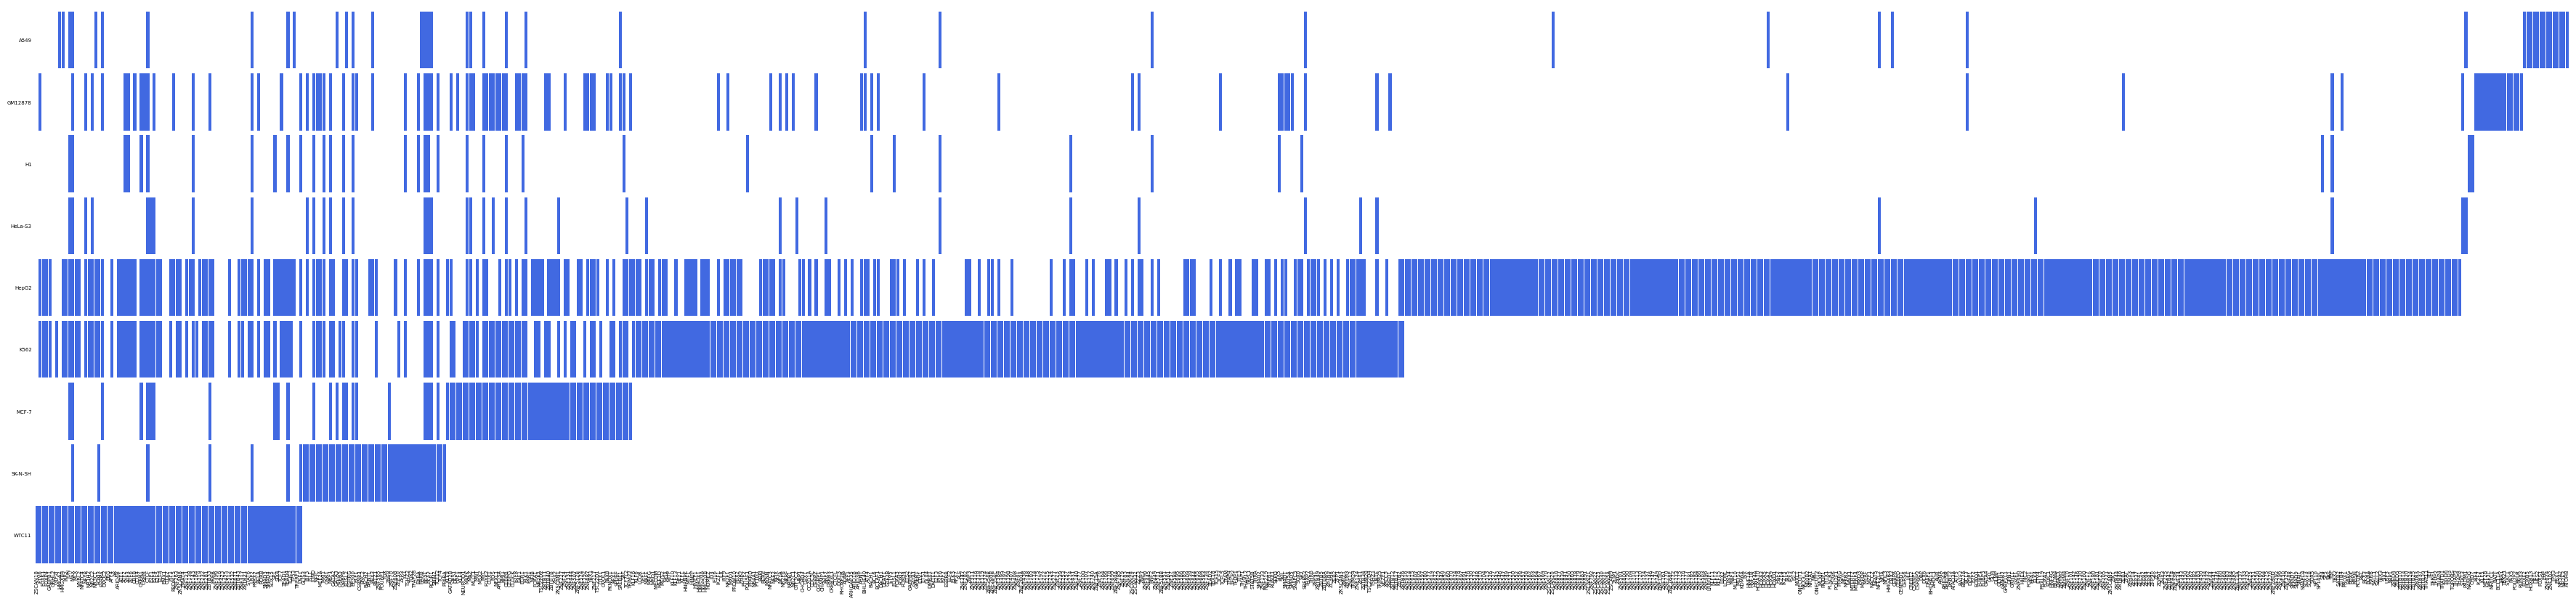

In [12]:
plt.rcParams.update({'font.size': 5})
mut_mapping={1:"#4169E1"}
download_table_comut = comut.CoMut()
download_table_comut.add_categorical_data(download_table.sort_values("category", ascending=False), name='value', mapping=mut_mapping)
download_table_comut.plot_comut(figsize = (45,10),x_padding = 0.04, y_padding = 0.04)
#plt.xticks([])  
plt.savefig("/Users/cmf/Downloads/TFNet-single-tf/results/download_celltype_tfs.2.pdf")

In [ ]:
download_table = pd.merge(download_table,download_table['sample'].value_counts().to_frame().reset_index(),how="left", on="sample")
download_table['group'] = ["1" if i == 1 else "2" if i == 2 else ">3" for i in download_table['count']]
download_table[['category','group']].groupby("category").value_counts(normalize=True).to_frame().reset_index()

In [ ]:
sns.barplot(download_table[['category','group']].groupby("category").value_counts(normalize=True).to_frame().reset_index(), x="category", y="proportion", hue="group", dodge=False)
plt.show()

In [ ]:
'''
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,8))
ax = sns.histplot(
    data=download_table,
    x="category", hue="group",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)
plt.xlabel("")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.savefig("results/distribute.normalize.2.pdf")

plt.figure(figsize=(8,8))
ax = sns.histplot(
    data=download_table,
    x="category", hue="group",
    multiple="stack", stat="count",
    discrete=True, shrink=.8
)
plt.xlabel("")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.savefig("results/distribute.2.pdf")
'''

In [ ]:
fig, axs = plt.subplots(ncols=2)
plt.rcParams.update({'figsize': (16,8)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

sns.histplot(
    data=download_table.sort_values(['category','group']),
    x="category", hue="group",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, ax=axs[0], legend=False
)
axs[0].set(xlabel='')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

sns.histplot(
    data=download_table.sort_values(['category','group']),
    x="category", hue="group",
    multiple="stack", stat="count",
    discrete=True, shrink=.8, ax=axs[1]
)
axs[1].set(xlabel='')
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(0.9, 1), title=None, frameon=False)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

fig.savefig("results/distribute.pdf")

In [ ]:
enable_labels = set(download_table[['category', 'family']].groupby('category').apply(lambda x:x.value_counts("family").head(5)).to_frame().reset_index()['family'])
download_table['enable_lable'] = [i if i in enable_labels else "other"  for i in download_table['family']]

In [ ]:
'''
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,8))
ax = sns.histplot(
    data=download_table.sort_values(['category','enable_lable']),
    x="category", hue="enable_lable",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)
plt.xlabel("")
plt.xticks(rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("results/distribute.family.normalize.pdf")
#plt.show()

sns.histplot(
    data=download_table.sort_values(['category','enable_lable']),
    x="category", hue="enable_lable",
    multiple="stack", stat="count",
    discrete=True, shrink=.8
)
plt.xlabel("")
plt.xticks(rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("results/distribute.family.pdf")
'''

In [ ]:
fig, axs = plt.subplots(ncols=2)
plt.rcParams.update({'figsize': (16,8)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

sns.histplot(
    data=download_table.sort_values(['category','enable_lable']),
    x="category", hue="enable_lable",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, ax=axs[0], legend=False
)
axs[0].set(xlabel='')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

sns.histplot(
    data=download_table.sort_values(['category','enable_lable']),
    x="category", hue="enable_lable",
    multiple="stack", stat="count",
    discrete=True, shrink=.8, ax=axs[1]
)
axs[1].set(xlabel='')
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(0.9, 1), title=None, frameon=False)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

fig.savefig("results/distribute.family.pdf")

In [ ]:
download_table2 = download_table.pivot_table(index="sample", columns="category", values="value")
download_table2[download_table2.isna()] = 0

In [ ]:
#plt.figure(figsize=(6,150))
sns.heatmap(download_table2,cmap=["white", "blue"])
plt.show()

### select overlap tfs for valid cross celltype performance under the circumcetance of similarity

In [3]:
download_table = pd.read_csv("/Users/cmf/Downloads/TFNet-single-tf/data/encode/encode_grch38_spider.download.csv", header=0)
download_table = download_table[['Target', 'Biosample']]
download_table = download_table[~download_table['Biosample'].isin(["HEK293"])]
download_table['value'] = 1
download_table.columns =  ['sample','category','value']
download_table = download_table.sort_values(["category","sample"])

#download_table.pivot_table(index="Target", columns="Biosample", values="value")


download_table2 = download_table.pivot_table(index="sample", columns="category", values="value")
download_table2[download_table2.isna()] = 0

In [4]:
download_table2[download_table2['H1'] + download_table2['SK-N-SH'] + download_table2['WTC11'] == 3]

category,A549,GM12878,H1,HeLa-S3,HepG2,K562,MCF-7,SK-N-SH,WTC11
sample,,,,,,,,,
CTCF,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MAX,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TEAD4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
USF1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
USF2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [ ]:
download_table2[download_table2.sum(axis=1) == 9]

SK-N-SH: 51 / CTCF 6 / MAX 19
H1: 38 / CTCF 7 / MAX 16
MCF-7: 80 / CTCF 7 / MAX 33
GM12878: 109 / CTCF 17 / MAX 43

WTC11: 82 / CTCF 12 / MAX 32